# Quora Question Pairs Competition

# (1) Exploratory Data Analysis

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
# %matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
!pip install distance
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## (1.1)Reading data and Basic Stats

In [0]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

df.head()

df.info()

Number of data points: 404290
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


### (1.1.1) Distribution of data points among output classes

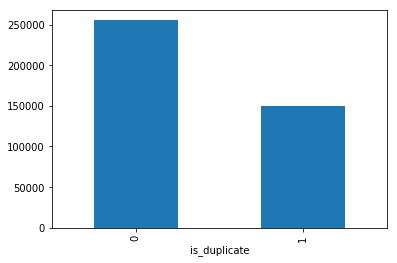

In [0]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))


~> Total number of question pairs for training:
   404290


In [0]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))


~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [0]:
df['is_duplicate'].value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

### (1.1.2) Number of unique questions

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values



Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



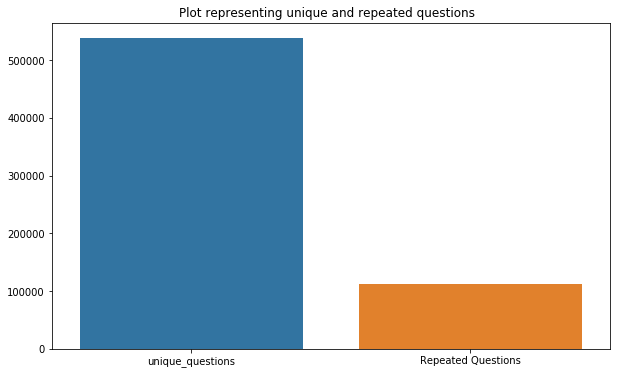

In [0]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

### (1.1.3) Checking for Duplicates

In [0]:
#checking whether there are any repeated pair of questions
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


### (1.1.4) Number of occurrences of each question

Maximum number of times a single question is repeated: 157



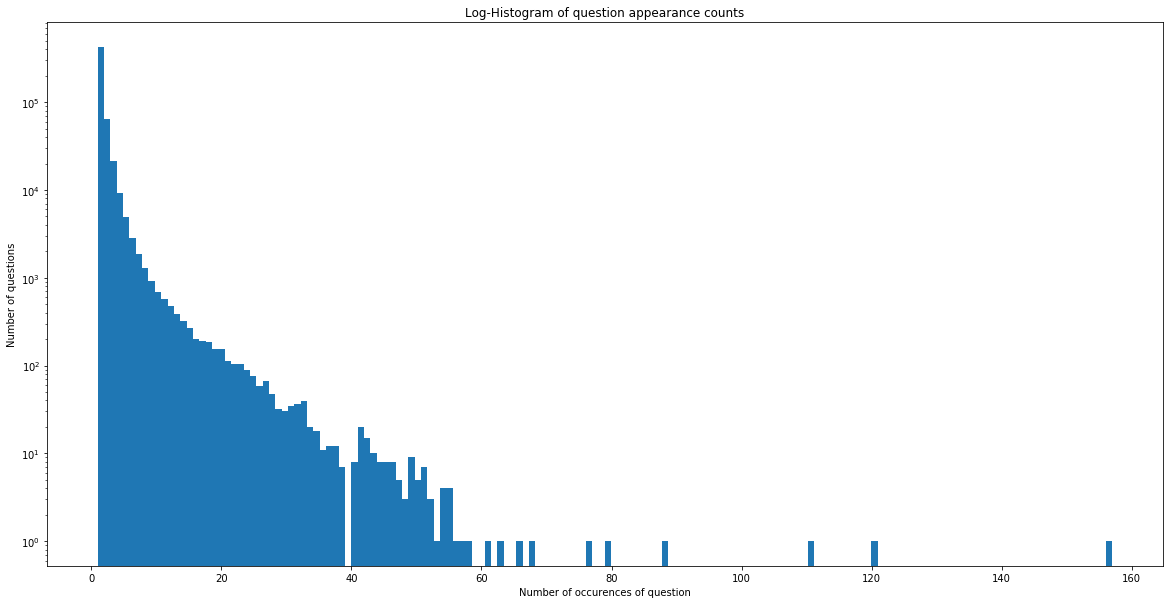

In [0]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

### (1.1.5) Checking for NULL values

In [0]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


In [0]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## (1.2) Basic Feature Extraction (before cleaning)

### Some basic feature extraction:
#### - freq_qid1: number of times qid1 appeared in whole question1.
#### - freq_qid2: number of times qid2 appeared in whole question2.
#### - q1len: length of q1.
#### - q2len: length of q1.
#### - q1_n_words: number of words in q1.
#### - q2_n_words: number of words in q2.
#### - word_common: number of common words in q1 & q2.
#### - word-total: total number of word in q1 & q2.
#### - word_share: number of common words in q1 & q2/(total number of word in q1 & q2).
#### - freq_q1+freq_q2: sum total of frequency of qid1 and qid2
#### - freq_q1-freq_q2: absolute difference of frequency of qid1 and qid2 


In [0]:
# Feature Exraction:  

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()


### (1.2.1) Analysis of some of the extracted features

In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

### (1.2.1.1) Feature: word_share

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()


#### The distributions for word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity.
#### The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar).
#### If we try to viusalize box-plot then easily see overlapping between two classes.



### (1.2.1.2) Feature: word_Common

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

#### Distribution of word_common feature for both classes (similar and Non-similar Que.) highly overlapped.
#### Here is also some correlation between word_share  & word_common.

### (1.2.1.3) Feature: freq_q1+q2

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'freq_q1+q2', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['freq_q1+q2'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['freq_q1+q2'][0:] , label = "0" , color = 'blue' )
plt.show()

#### feature freq_q1+q2 not giving any difference between similar and non-similar question.

### (1.2.1.4) Feature: freq_q1-q2

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'freq_q1-q2', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['freq_q1-q2'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['freq_q1-q2'][0:] , label = "0" , color = 'blue' )
plt.show()

## (1.2.2) EDA: Advanced Feature Extraction

In [0]:
!pip install  wordcloud

!pip install fuzzywuzzy

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
# %matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc


import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
from wordcloud import WordCloud, STOPWORDS
from os import path


In [0]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [0]:
df.head(2)

# (2) Preprocessing of Text

### Preprocessing :
### Removing html tags, Removing Punctuations, Performing stemming, Removing Stopwords, Expanding contractions etc

In [0]:
#to get results in 4decimal points.
SAFE_DIV = 0.0001 

import nltk
nltk.download('stopwords')
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

# (2.1) Advanced Feature Extraction

### Definitions:

    Token: You get a token by splitting sentence a space
    Stop_Word : stop words as per NLTK.
    Word : A token that is not a stop_word

### Features:

    cwc_min : Ratio of common_word_count to min length of word count of Q1 and Q2 without stopword
    cwc_min = common_word_count / (min(len(q1_words), len(q2_words))


    cwc_max : Ratio of common_word_count to max length of word count of Q1 and Q2 without stopword.
    cwc_max = common_word_count / (max(len(q1_words), len(q2_words))


    csc_min : Ratio of common_stop_count to min length of stop count of Q1 and Q2
    csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))


    csc_max : Ratio of common_stop_count to max length of stop count of Q1 and Q2
    csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))


    ctc_min : Ratio of common_token_count to min length of token count of Q1 and Q2
    ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))


    ctc_max : Ratio of common_token_count to max length of token count of Q1 and Q2
    ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))


    last_word_eq : Check if last word of both questions is equal or not
    last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])


    first_word_eq : Check if First word of both questions is equal or not
    first_word_eq = int(q1_tokens[0] == q2_tokens[0])


    abs_len_diff : Abs. length difference
    abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))


    mean_len : Average Token Length of both Questions
    mean_len = (len(q1_tokens) + len(q2_tokens))/2
    
### Fuzzywuzzy features:
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
      

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    print("fuzzy features..");

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df


In [0]:

if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)


## (2.1.1) Analysis of extracted features

### (2.1.1.1)Plotting Words Clouds

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='utf-8')

In [0]:

# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

In [0]:
"""__ Word Clouds generated from  duplicate pair question's text __"""

wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [0]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### (2.1.1.2) Pair plot of features:    ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [0]:

#token_sort_ratio is interesting feature because they dont fully  overlap.
#ideally they should fully seperated

plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()


## (2.1.2) Visualization

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 2 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values



In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)



In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

In [0]:

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')


## (2.2) Featurizing text data with tfidf weighted word-vectors

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm



In [0]:
import spacy

!pip install spacy

In [0]:
df = pd.read_csv("train.csv")

In [0]:
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head()


In [0]:
#computing tfidf weighted W2V 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
#spacy is the pretrained glove model.
# https://spacy.io/usage/vectors-similarity

import spacy


nlp = spacy.load('en_core_web_sm')
vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
            
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [0]:

vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [0]:

#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)

if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

    
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")



In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)


In [0]:

# dataframe of nlp features
df1.head()

In [0]:

# data before preprocessing 
df2.head()


In [0]:

# Questions 1 tfidf weighted word2vec
df3_q1.head()


In [0]:

# Questions 2 tfidf weighted word2vec
df3_q2.head()


In [0]:

print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])


In [0]:

# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')


# (3) Machine Learning Models

In [0]:
#importing various Libraries:

import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

!pip install mlxtend



## (3.1) Reading data from file and storing into sql table

In [0]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1


In [0]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))



In [0]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

In [0]:
# try to sample data according to the computing power
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()


In [0]:

# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [0]:
data.head()

## (3.2) Converting strings to numerics

In [0]:
cols = list(data.columns)
for i in cols:
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

In [0]:
y_true = list(map(int, y_true.values))

## (3.3) Random train test split

In [0]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)

In [0]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)


In [0]:

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

## (3.4) Building a random model (Finding worst-case log-loss)

In [0]:
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

## (3.5) Logistic Regression with hyperparameter tuning

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [0]:

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_std = scale.fit_transform(X_train)
X_test_std = scale.transform(X_test)


alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_y = sig_clf.predict_proba(X_test_std)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

predict_y = sig_clf.predict_proba(X_train_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


## (3.6) Linear SVM with hyperparameter tuning

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)



In [0]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_std_std = scale.fit_transform(X_train)
X_test_std_std = scale.transform(X_test)

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_std, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_std, y_train)
    predict_y = sig_clf.predict_proba(X_test_std)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_std, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_std, y_train)

predict_y = sig_clf.predict_proba(X_train_std)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_std)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## (3.7) Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

estimators = [100,150,200,300,400,600,800,1000]#parameter tuning of n_estimators
test_scores = []
train_scores = []
for i in estimators:
    clf = RandomForestClassifier(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')



In [0]:
from sklearn.ensemble import RandomForestClassifier
max_depth = [5,10,12,15,20,25,50]#parameter tuning of max_depth
test_scores = []
train_scores = []
for i in max_depth:
    clf = RandomForestClassifier(n_estimators=200,max_depth=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('max_depth = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(max_depth,train_scores,label='Train Log Loss')
plt.plot(max_depth,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')


## (3.8) XGBoost

In [0]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [0]:

predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


In [0]:

import xgboost as xgb
estimators = [100,200,250,300,350,400,600]  #parameter tuning of estimators (no. of base learners.)
test_scores = []
train_scores = []
for i in estimators:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.1,n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators')
plt.ylabel('Log Loss')


In [0]:

test_scores = []
train_scores = []
etas = [0.05,0.1,0.15,0.2,0.25,0.3]  #parameter tuning of learning rate.
for i in etas:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=i,n_estimators=350,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('etas = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(etas,train_scores,label='Train Log Loss')
plt.plot(etas,test_scores,label='Test Log Loss')
plt.xlabel('Learning rate')
plt.ylabel('Log Loss')

In [0]:
test_scores = []
train_scores = []
alpha = [0.5,1,5,10,50,100,150]#parameter tuning of alpha
for i in alpha:
    clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.15,n_estimators=350,reg_alpha=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('reg_alpha = ',i,'\Train Log Loss ',log_loss_train,'\Test Log Loss ',log_loss_test,'\Loss difference between Test and Train',(log_loss_test-log_loss_train))
plt.plot(alpha,train_scores,label='Train Log Loss')
plt.plot(alpha,test_scores,label='Test Log Loss')
plt.xlabel('reg_alpha')
plt.ylabel('Log Loss')


In [0]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=3,learning_rate=0.15,n_estimators=350,n_jobs=-1)
clf.fit(X_train,y_train)
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test, predicted_y)

## (4) Converting Text data in TF-IDF vector

In [0]:
data.columns

In [0]:
data.info()

In [0]:
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = dfnlp[['id','question1','question2']]
duplicate = dfnlp.is_duplicate

In [0]:
df3 = df3.fillna(' ')
df4 = pd.DataFrame()
df4['Text'] = df3.question1 + ' ' + df3.question2
df4['id'] = df3.id

In [0]:
#Combining question1 and question2, then getting Tf-Idf
df2['id']=df1['id']
df4['id']=df1['id']
df5  = df1.merge(df2, on='id',how='left')
final  = df5.merge(df4, on='id',how='left')

In [0]:
final = final.drop('id',axis=1)

In [0]:
#train test split
X_train_tfidf,X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(final,duplicate,  test_size=0.3,random_state=24)


In [0]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,4),max_features=200000,min_df=0.000032)
train_tfidf = tfidf_vect.fit_transform(X_train_tfidf.Text)
test_tfidf = tfidf_vect.transform(X_test_tfidf.Text)
print('length of Tfidf features',len(tfidf_vect.get_feature_names()))

In [0]:
X_train_tfidf = X_train_tfidf.drop('Text',axis=1)
X_test_tfidf = X_test_tfidf.drop('Text',axis=1)

In [0]:
from scipy.sparse import hstack
X_train1 = hstack((X_train_tfidf.values,train_tfidf))
X_test1 = hstack((X_test_tfidf.values,test_tfidf))


In [0]:
"""standardized"""

scale = StandardScaler(with_mean=False)
X_train_stdn = scale.fit_transform(X_train_tfidf)
X_test_stdn = scale.transform(X_test_tfidf)

In [0]:

from scipy.sparse import hstack
X_train_scale = hstack((X_train_stdn,train_tfidf))
X_test_scale = hstack((X_test_stdn,test_tfidf))

## (4.1) Logistic Regression with hyperparameter tuning(tfidf)

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train1, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train1, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train1)
log_loss_train_logistic=log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss_train_logistic)
predict_y = sig_clf.predict_proba(X_test1)
log_loss_test_logistic=log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss_test_logistic)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)


In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_scale, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_scale, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_test_scale)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_scale, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_scale, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_scale)
log_loss_train_logistic_scaled=log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss_train_logistic_scaled)
predict_y = sig_clf.predict_proba(X_test_scale)
log_loss_test_logistic_scaled=log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss_test_logistic_scaled)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)

## (4.2) Linear SVM with hyperparameter tuning(tfidf)

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train1, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train1, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_test1)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train1, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train1, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train1)
log_loss_train_svm=log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss_train_svm)
predict_y = sig_clf.predict_proba(X_test1)
log_loss_test_svm=log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss_test_svm)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)


In [0]:

"""with standardized scaled dataset"""

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train_scale, y_train_tfidf)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_scale, y_train_tfidf)
    predict_y = sig_clf.predict_proba(X_test_scale)
    log_error_array.append(log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train_scale, y_train_tfidf)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_scale, y_train_tfidf)

predict_y = sig_clf.predict_proba(X_train_scale)
log_loss_train_svm_scaled=log_loss(y_train_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss_train_svm_scaled)
predict_y = sig_clf.predict_proba(X_test_scale)
log_loss_test_svm_scaled=log_loss(y_test_tfidf, predict_y, labels=clf.classes_, eps=1e-15)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss_test_svm_scaled)
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test_tfidf, predicted_y)


## (4.3) XGBoost(tfidf)

In [0]:
import pickle

In [0]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
import random,math
from random import randint
from random import uniform

param_dist = {"max_depth": [randint(2,5)],
              "learning_rate":[uniform(0,0.25)],
              "n_estimators":[randint(100,600)],
              "min_child_weight": [randint(2, 8)],
              "gamma": [uniform(0,4)],
              "subsample":[uniform(0.3,0.7)],
              "colsample_bytree": [uniform(0.3,0.7)],
              "reg_alpha":[uniform(100,300)],
              "reg_lambda":[uniform(100,300)]}

xgb_classifier= xgb.XGBClassifier(n_jobs=-1,random_state=25)
model_rs_xgb = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist,n_iter=30,scoring='neg_log_loss',cv=10,n_jobs=-1)
model_rs_xgb.fit(X_train_scale,y_train_tfidf)
pickle.dump(model_rs_xgb,open('model_rs_xgb.p','wb'))


In [0]:
model_rs_xgb.best_params_


In [0]:
import xgboost as xgb
clf = xgb.XGBClassifier(max_depth=4,learning_rate=0.18739843716109036,n_estimators=455,min_child_weight=3,
                        reg_alpha=147.48355681277022,reg_lambda=298.24507830962364,
                        gamma=0.08991146971048991,colsample_bytree=0.3395793695766003,n_jobs=-1)
clf.fit(X_train_scale,y_train_tfidf)
y_pred_test=clf.predict_proba(X_test_scale)
y_pred_train=clf.predict_proba(X_train_scale)
log_loss_train_xgb = log_loss(y_train_tfidf, y_pred_train, eps=1e-15)
log_loss_test_xgb=log_loss(y_test_tfidf,y_pred_test,eps=1e-15)
print('Train log loss = ',log_loss_train_xgb,' Test log loss = ',log_loss_test_xgb)
predicted_y =np.argmax(predict_y,axis=1)
plot_confusion_matrix(y_test_tfidf, predicted_y)


In [0]:

!pip install PrettyTable

In [0]:

from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","vectorizer","logloss_train","logloss_test","logloss_train(with standardized)","logloss_test(with standardized)"]
x.add_row(['Random model','TFIDF w2vec', '---'  , '0.8851460427625617','---','---'])
x.add_row(['Logistic regression','TFIDF w2vec','0.50036000082','0.505431586320','0.403156873165','0.413104155793449'])
x.add_row(['Linear SVM','TFIDF w2vec','0.478578596724142','0.4876647905346559','0.4180234067450405','0.4268263608040993'])
x.add_row(['XGBOOST','TFIDF w2vec', '0.341883'  , '0.354821','---','---'])
x.add_row(['Logistic regression','TFIDF ',log_loss_train_logistic   , log_loss_test_logistic , log_loss_train_logistic_scaled,log_loss_test_logistic_scaled])
x.add_row(['Linear SVM','TFIDF',  log_loss_train_svm  , log_loss_test_svm,log_loss_train_svm_scaled,log_loss_test_svm_scaled])
x.add_row(['XGBOOST_tuned','TFIDF ',log_loss_train_xgb,log_loss_test_xgb,'---','---'])

print(x)


In [0]:

from prettytable import PrettyTable

data = x.get_string()

with open('Quora.txt', 'w') as f:
    f.write(data)